In [1]:
%reload_ext autoreload
%autoreload 2

In [96]:
%matplotlib inline

import torchvision as tv
import torch
from pathlib import Path
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

import seaborn as sns

In [32]:
def load_data():
    filepaths = glob('imgs/*.jpeg')
    images = [Image.open(fp).convert("RGB") for fp in filepaths]
    names = [Path(fp).name for fp in filepaths]

    return names, images

names, images = load_data()
names

['dylan.jpeg', 'soiree.jpeg', 'another_soiree.jpeg']

In [33]:
idx = 1

In [34]:
def predict(image):
    model = tv.models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()
    to_tensor = tv.transforms.ToTensor()
    tensor = to_tensor(image)
    pred = model([tensor])[0]
    return pred

labels = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

pred = predict(images[idx])
pred

{'boxes': tensor([[1.0035e+02, 1.4694e+02, 2.6030e+02, 2.8213e+02],
         [3.1692e+02, 1.3695e+02, 3.6976e+02, 2.1682e+02],
         [6.1224e+01, 1.3969e+02, 1.5408e+02, 2.7350e+02],
         [2.3103e+02, 1.1371e+02, 2.6837e+02, 1.7438e+02],
         [1.5476e+01, 1.3955e+02, 9.3408e+01, 2.5749e+02],
         [3.7842e+02, 1.3435e+02, 4.5794e+02, 2.5031e+02],
         [4.3052e+02, 1.2609e+02, 4.7111e+02, 1.7883e+02],
         [2.6400e+02, 1.9297e+02, 3.4751e+02, 2.8170e+02],
         [3.7373e+02, 2.1615e+02, 3.9134e+02, 2.5638e+02],
         [7.8130e+01, 1.1210e+02, 1.1386e+02, 1.5559e+02],
         [2.5942e+02, 1.2162e+02, 2.9552e+02, 1.7309e+02],
         [3.5655e+02, 1.2536e+02, 4.0453e+02, 1.7934e+02],
         [2.9221e+02, 1.1106e+02, 3.1872e+02, 1.4852e+02],
         [3.0555e+02, 1.1765e+02, 3.3969e+02, 1.6965e+02],
         [1.8279e+02, 1.2367e+02, 2.3003e+02, 1.7982e+02],
         [2.5217e+02, 1.5702e+02, 2.9466e+02, 1.9499e+02],
         [3.5974e+02, 2.2426e+02, 3.7937e+02, 2

In [39]:
label_names = [labels[i] for i in pred['labels']]
scores = pred['scores'].squeeze().tolist()
masks = pred['masks']

In [40]:
threshold = 0.5

In [41]:
label_names = [ln for ln, score in zip(label_names, scores) if score > threshold]
masks = [masks[i, :, :] for i, score in enumerate(scores) if score > threshold]

set(label_names)

{'book', 'chair', 'cup', 'dining table', 'person', 'wine glass'}

In [46]:
mask_name = 'wine glass'

In [47]:
base_image = images[idx]
selected_masks = [mask for ln, mask in zip(label_names, masks) if ln == mask_name]

In [48]:
len(selected_masks)

3

In [62]:
[m.shape for m in selected_masks]

[torch.Size([1, 285, 600]),
 torch.Size([1, 285, 600]),
 torch.Size([1, 285, 600])]

In [65]:
[m.max() for m in selected_masks]

[tensor(0.9940, grad_fn=<MaxBackward1>),
 tensor(0.9887, grad_fn=<MaxBackward1>),
 tensor(0.9994, grad_fn=<MaxBackward1>)]

In [61]:
torch.stack(selected_masks).shape
3 x 1 x 285 x 600

torch.Size([3, 1, 285, 600])

In [93]:
final_mask = torch.stack(selected_masks).max(axis=0).values
final_mask

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<MaxBackward0>)

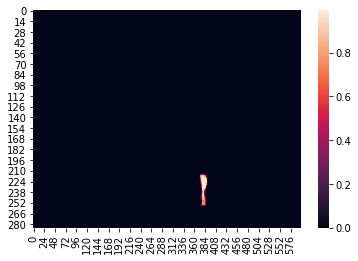

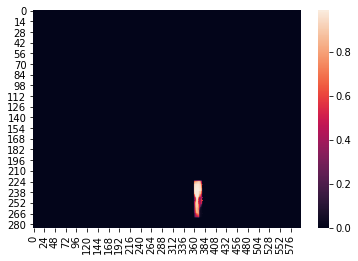

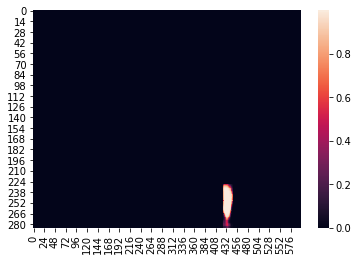

In [102]:
for mask in selected_masks:
    sns.heatmap(mask.detach().numpy()[0])
    plt.show()

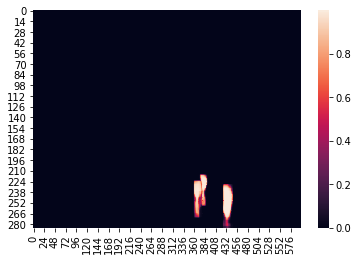

In [97]:
sns.heatmap(final_mask.detach().numpy()[0])

In [86]:
tensor_to_pil = tv.transforms.ToPILImage
Image(tensor_to_pil(final_mask))

TypeError: 'module' object is not callable

In [103]:
mask_image = final_mask.detach().numpy().transpose(1, 2, 0)
mask_image.shape

(285, 600, 1)

In [104]:
base_image = images[idx]

In [116]:
(np.array(base_image) / 255.) * 0.4 + mask_image * 0.6

array([[[0.28078431, 0.22588235, 0.09882353],
        [0.27921569, 0.22431373, 0.0972549 ],
        [0.27921569, 0.22431373, 0.0972549 ],
        ...,
        [0.24941176, 0.09411765, 0.06431373],
        [0.24470588, 0.08941176, 0.05960784],
        [0.24      , 0.08470588, 0.05490196]],

       [[0.28235294, 0.22588235, 0.09411765],
        [0.28078431, 0.22431373, 0.08941176],
        [0.28078431, 0.22431373, 0.08941176],
        ...,
        [0.24941176, 0.09411765, 0.06431373],
        [0.24313725, 0.08784314, 0.05803922],
        [0.23686275, 0.08156863, 0.05176471]],

       [[0.28235294, 0.22745098, 0.08      ],
        [0.28078431, 0.22588235, 0.07843137],
        [0.28078431, 0.22588235, 0.07843137],
        ...,
        [0.24784314, 0.09254902, 0.0627451 ],
        [0.24156863, 0.08627451, 0.05647059],
        [0.23372549, 0.07843137, 0.04862745]],

       ...,

       [[0.00784314, 0.01254902, 0.04235294],
        [0.00784314, 0.01254902, 0.04235294],
        [0.00784314, 0

In [79]:
import numpy as np

In [81]:
Image.fromarray(mask_image*255)

TypeError: Cannot handle this data type: (1, 1, 1), <f4

In [3]:
model = tv.models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()

In [15]:
filepaths = list(Path('imgs/').glob('*.jpeg'))
filepaths
# filenames = [fp.name for fp in filepaths]

[PosixPath('imgs/dylan.jpeg'),
 PosixPath('imgs/soiree.jpeg'),
 PosixPath('imgs/another_soiree.jpeg')]

In [13]:
filepaths

[]

In [5]:
[load_image(fp) for fp in list(filepaths)]

[]

In [7]:
[print(fp) for fp in filepaths]

[]

In [21]:
!ls imgs

another_soiree.jpeg dylan.jpeg          soiree.jpeg


In [23]:
Photo('')

FileNotFoundError: [Errno 2] No such file or directory: ''